# Developing a Fraud Detection Model for PayPal
# Daniel Guthrie

## Formatting Data

In [134]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

In [135]:
# Loading dataset
data = pd.read_csv('data/synthetic_fraud_dataset.csv')
sfd = data

In [136]:
# Looking at dataset
data.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,0,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,0,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,1,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [137]:
# Getting dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

In [138]:
# Converting timestamp to datetime 
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [139]:
# Extracting time-based features
data['hour'] = data['Timestamp'].dt.hour
data['day_of_week'] = data['Timestamp'].dt.dayofweek 
data['day'] = data['Timestamp'].dt.day
data['month'] = data['Timestamp'].dt.month
data['year'] = data['Timestamp'].dt.year

In [140]:
# Dropping irrelevant columns from dataset
data = data.drop(['Transaction_ID', 'User_ID', 'Timestamp'], axis=1)

In [141]:
# Creating list of dtype 'object' columns
object_columns = data.select_dtypes(include=['object']).columns

In [142]:
# Converting object columns into dummy variables
data = pd.get_dummies(data, columns=object_columns)

In [143]:
# Viewing new dataset
data.head()

,Transaction_Amount,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,Is_Weekend,Fraud_Label,hour,day_of_week,day,month,year,Transaction_Type_ATM Withdrawal,Transaction_Type_Bank Transfer,Transaction_Type_Online,Transaction_Type_POS,Device_Type_Laptop,Device_Type_Mobile,Device_Type_Tablet,Location_London,Location_Mumbai,Location_New York,Location_Sydney,Location_Tokyo,Merchant_Category_Clothing,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Card_Type_Amex,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa,Authentication_Method_Biometric,Authentication_Method_OTP,Authentication_Method_PIN,Authentication_Method_Password
0,39.79,93213.17,0,0,7,437.63,3,65,883.17,0.8494,0,0,19,0,14,8,2023,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,True,False,False,False
1,1.19,75725.25,0,0,13,478.76,4,186,2203.36,0.0959,0,1,4,2,7,6,2023,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
2,28.96,1588.96,0,0,14,50.01,4,226,1909.29,0.8400,0,1,15,1,20,6,2023,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False
3,254.32,76807.20,0,0,8,182.48,4,76,1311.86,0.7935,0,1,0,3,7,12,2023,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False
4,31.28,92354.66,0,1,14,328.69,4,140,966.98,0.3819,1,1,23,5,11,11,2023,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True


In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Transaction_Amount               50000 non-null  float64
 1   Account_Balance                  50000 non-null  float64
 2   IP_Address_Flag                  50000 non-null  int64  
 3   Previous_Fraudulent_Activity     50000 non-null  int64  
 4   Daily_Transaction_Count          50000 non-null  int64  
 5   Avg_Transaction_Amount_7d        50000 non-null  float64
 6   Failed_Transaction_Count_7d      50000 non-null  int64  
 7   Card_Age                         50000 non-null  int64  
 8   Transaction_Distance             50000 non-null  float64
 9   Risk_Score                       50000 non-null  float64
 10  Is_Weekend                       50000 non-null  int64  
 11  Fraud_Label                      50000 non-null  int64  
 12  hour              

### All 'object' datatype columns were converted to dummy variables, except 'Timestamp'. 'Timestamp' was separated into hour, day of week, day, month, and year. Columns not relevant to fraud, 'Transaction_ID' and 'User_ID', were dropped. This left us with 41 columns in total. There were no null values present.

## Data Exploration and Visualization

In [145]:
# Separating dataset into fraud and not fraud for easy comparison
sfd_fraud = sfd[sfd['Fraud_Label'] == 1]
sfd_fraud.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16067 entries, 1 to 49999
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Transaction_ID                16067 non-null  object        
 1   User_ID                       16067 non-null  object        
 2   Transaction_Amount            16067 non-null  float64       
 3   Transaction_Type              16067 non-null  object        
 4   Timestamp                     16067 non-null  datetime64[ns]
 5   Account_Balance               16067 non-null  float64       
 6   Device_Type                   16067 non-null  object        
 7   Location                      16067 non-null  object        
 8   Merchant_Category             16067 non-null  object        
 9   IP_Address_Flag               16067 non-null  int64         
 10  Previous_Fraudulent_Activity  16067 non-null  int64         
 11  Daily_Transaction_Count       160

In [146]:
sfd_safe = sfd[sfd['Fraud_Label'] == 0]
sfd_safe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33933 entries, 0 to 49997
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Transaction_ID                33933 non-null  object        
 1   User_ID                       33933 non-null  object        
 2   Transaction_Amount            33933 non-null  float64       
 3   Transaction_Type              33933 non-null  object        
 4   Timestamp                     33933 non-null  datetime64[ns]
 5   Account_Balance               33933 non-null  float64       
 6   Device_Type                   33933 non-null  object        
 7   Location                      33933 non-null  object        
 8   Merchant_Category             33933 non-null  object        
 9   IP_Address_Flag               33933 non-null  int64         
 10  Previous_Fraudulent_Activity  33933 non-null  int64         
 11  Daily_Transaction_Count       339

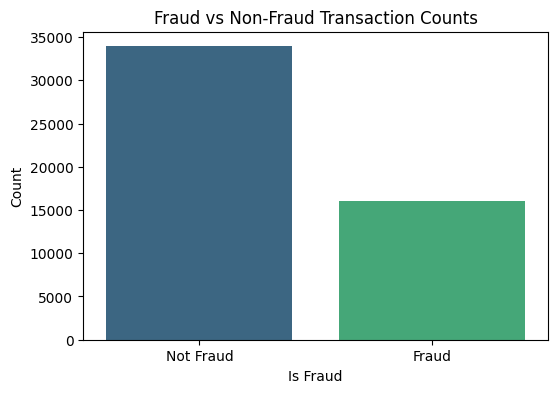

In [147]:
# Fraud vs. Non-Fraud Counts
plt.figure(figsize=(6, 4))
sns.countplot(x='Fraud_Label', data=data, palette='viridis')
plt.title('Fraud vs Non-Fraud Transaction Counts')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

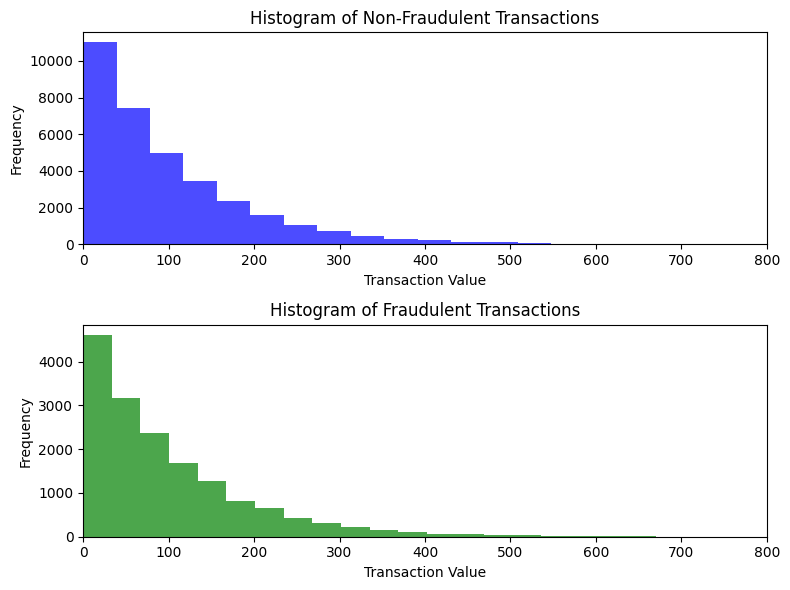

In [148]:
# Creating histograms of transaction value
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plotting the first histogram in the first subplot
axs[0].hist(sfd_safe['Transaction_Amount'], bins=30, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Non-Fraudulent Transactions')
axs[0].set_xlabel('Transaction Value')
axs[0].set_ylabel('Frequency')

axs[0].set_xlim(0, 800)

# Plotting the second histogram in the second subplot
axs[1].hist(sfd_fraud['Transaction_Amount'], bins=30, color='green', alpha=0.7)
axs[1].set_title('Histogram of Fraudulent Transactions')
axs[1].set_xlabel('Transaction Value')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.xlim(0, 800)


plt.show()

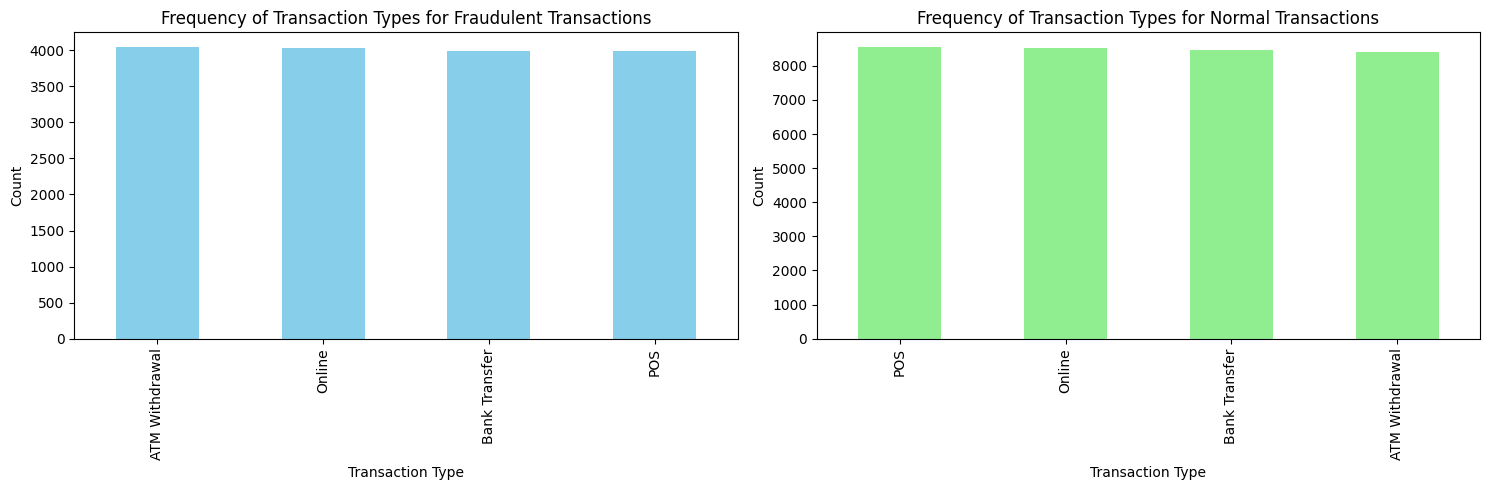

In [149]:
# Creating bar plots of transaction type
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), edgecolor='black')

# Bar plot for sfd_fraud
sfd_fraud['Transaction_Type'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Frequency of Transaction Types for Fraudulent Transactions')
axes[0].set_xlabel('Transaction Type')
axes[0].set_ylabel('Count')

# Bar plot for sfd_safe
sfd_safe['Transaction_Type'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Frequency of Transaction Types for Normal Transactions')
axes[1].set_xlabel('Transaction Type')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

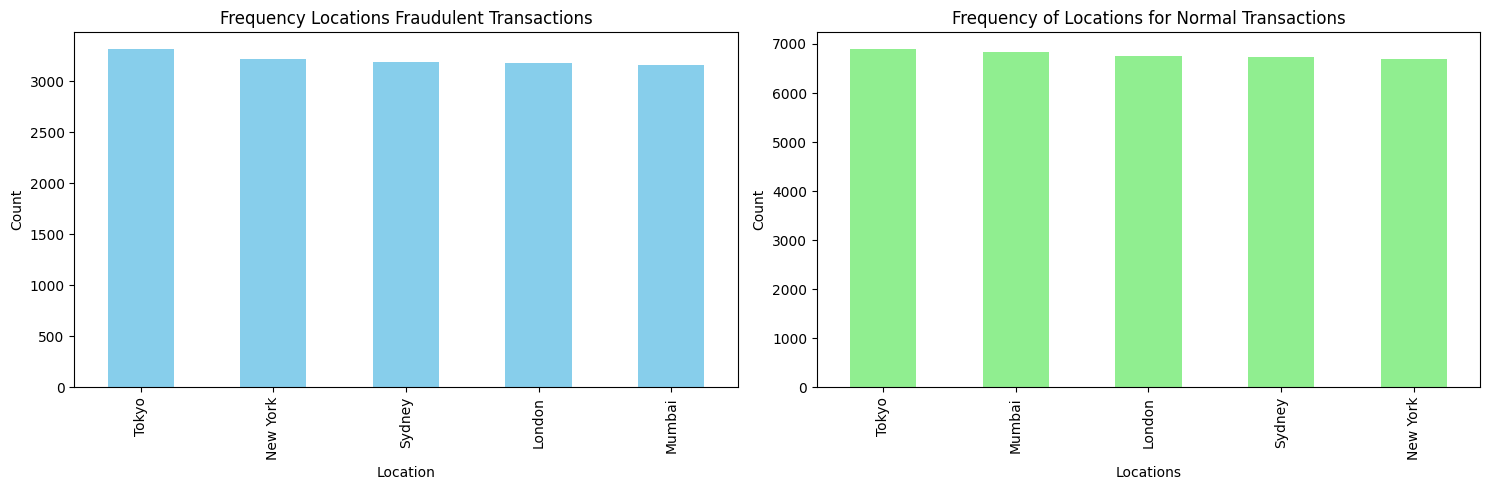

In [150]:
# Creating bar plots of location 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), edgecolor='black')

# Bar plot for sfd_fraud
sfd_fraud['Location'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Frequency Locations Fraudulent Transactions')
axes[0].set_xlabel('Location')
axes[0].set_ylabel('Count')

# Bar plot for sfd_safe
sfd_safe['Location'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Frequency of Locations for Normal Transactions')
axes[1].set_xlabel('Locations')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

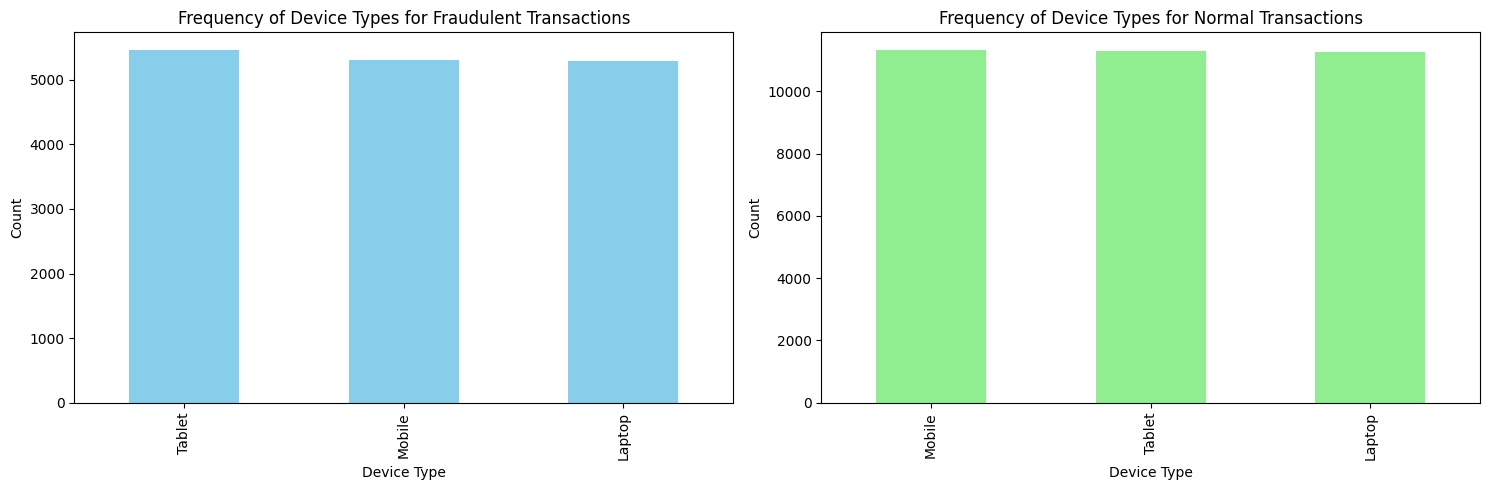

In [151]:
# Creating bar plots of device type
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), edgecolor='black')

# Bar plot for sfd_fraud
sfd_fraud['Device_Type'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Frequency of Device Types for Fraudulent Transactions')
axes[0].set_xlabel('Device Type')
axes[0].set_ylabel('Count')

# Bar plot for sfd_safe
sfd_safe['Device_Type'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Frequency of Device Types for Normal Transactions')
axes[1].set_xlabel('Device Type')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

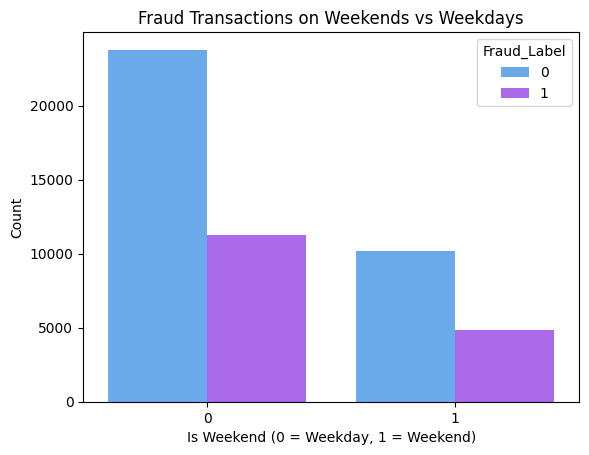

In [152]:
# Transactions on weekends vs weekdays
sns.countplot(x=data['Is_Weekend'], hue=data['Fraud_Label'], palette='cool')
plt.title("Fraud Transactions on Weekends vs Weekdays")
plt.xlabel("Is Weekend (0 = Weekday, 1 = Weekend)")
plt.ylabel("Count")
plt.show()

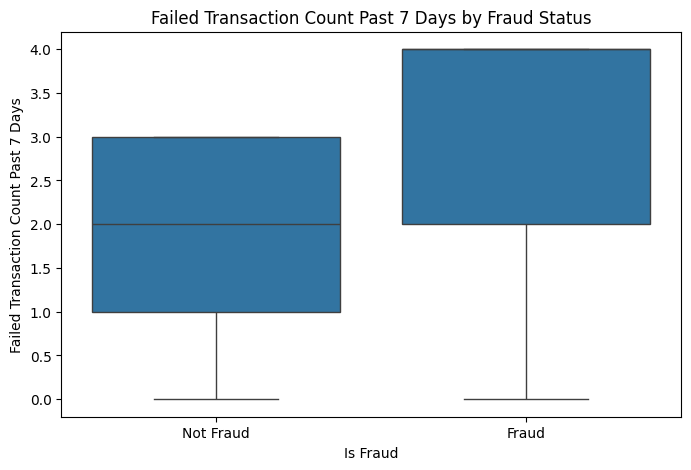

In [153]:
# Boxplot of Failed Transaction count for the past 7 days
plt.figure(figsize=(8, 5))
sns.boxplot(x='Fraud_Label', y='Failed_Transaction_Count_7d', data=data)
plt.title('Failed Transaction Count Past 7 Days by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Failed Transaction Count Past 7 Days')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

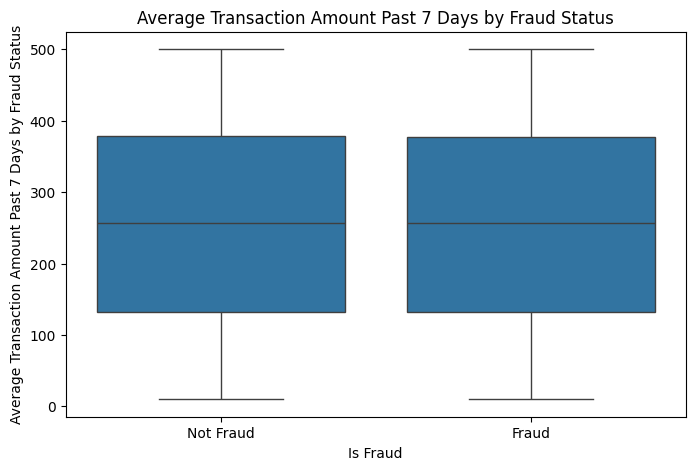

In [154]:
# Boxplot for avg transaction amount in the past 7 days
plt.figure(figsize=(8, 5))
sns.boxplot(x='Fraud_Label', y='Avg_Transaction_Amount_7d', data=data)
plt.title('Average Transaction Amount Past 7 Days by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Average Transaction Amount Past 7 Days by Fraud Status')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

In [155]:
# Getting Summary Stats for fraud dataset
summary_stats = sfd_fraud.describe()
summary_stats

,Transaction_Amount,Timestamp,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,Is_Weekend,Fraud_Label,hour,day_of_week,day,month,year
count,16067.000000,16067,16067.000000,16067.000000,16067.000000,16067.000000,16067.000000,16067.000000,16067.000000,16067.000000,16067.000000,16067.000000,16067.0,16067.000000,16067.000000,16067.000000,16067.000000,16067.0
mean,99.683678,2023-07-02 10:03:46.653389056,50162.264626,0.051161,0.098089,7.443767,255.416370,3.051472,119.687123,2498.922109,0.662904,0.299683,1.0,11.574781,3.031991,15.786643,6.521006,2023.0
min,0.000000,2023-01-01 00:46:00,503.940000,0.000000,0.000000,1.000000,10.000000,0.000000,1.000000,0.560000,0.000100,0.000000,1.0,0.000000,0.000000,1.000000,1.000000,2023.0
25%,28.485000,2023-04-01 11:02:00,24977.270000,0.000000,0.000000,4.000000,132.570000,2.000000,60.000000,1239.700000,0.405100,0.000000,1.0,6.000000,1.000000,8.000000,4.000000,2023.0
50%,70.120000,2023-07-02 11:50:00,50415.020000,0.000000,0.000000,7.000000,256.210000,4.000000,119.000000,2496.660000,0.806900,0.000000,1.0,12.000000,3.000000,16.000000,7.000000,2023.0
75%,139.520000,2023-10-01 14:12:00,74902.605000,0.000000,0.000000,11.000000,377.420000,4.000000,179.000000,3750.465000,0.919700,1.000000,1.0,17.000000,5.000000,23.000000,10.000000,2023.0
max,1005.320000,2023-12-31 23:50:00,99997.790000,1.000000,1.000000,14.000000,499.990000,4.000000,239.000000,4999.910000,1.000000,1.000000,1.0,23.000000,6.000000,31.000000,12.000000,2023.0
std,99.164651,NaN,28816.707667,0.220332,0.297445,4.038098,140.904511,1.396953,68.916261,1449.351039,0.306187,0.458133,0.0,6.881920,2.008533,8.826095,3.455661,0.0


In [156]:
# Getting summary stats for safe dataset
summary_stats = sfd_safe.describe()
summary_stats

,Transaction_Amount,Timestamp,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,Is_Weekend,Fraud_Label,hour,day_of_week,day,month,year
count,33933.000000,33933,33933.000000,33933.000000,33933.000000,33933.000000,33933.000000,33933.000000,33933.000000,33933.000000,33933.000000,33933.000000,33933.0,33933.000000,33933.000000,33933.000000,33933.000000,33933.0
mean,99.281907,2023-07-02 14:04:33.372822784,50356.472852,0.049745,0.098547,7.504877,255.203530,1.507353,120.148056,2499.278762,0.425158,0.299620,0.0,11.488728,3.009401,15.687443,6.529956,2023.0
min,0.010000,2023-01-01 00:01:00,500.480000,0.000000,0.000000,1.000000,10.010000,0.000000,1.000000,0.250000,0.000100,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,2023.0
25%,28.760000,2023-04-02 11:01:00,25530.160000,0.000000,0.000000,4.000000,131.880000,1.000000,60.000000,1265.480000,0.215100,0.000000,0.0,5.000000,1.000000,8.000000,4.000000,2023.0
50%,69.400000,2023-07-02 14:59:00,50370.350000,0.000000,0.000000,7.000000,256.050000,2.000000,120.000000,2487.680000,0.426300,0.000000,0.0,12.000000,3.000000,16.000000,7.000000,2023.0
75%,138.490000,2023-10-01 04:12:00,75217.280000,0.000000,0.000000,11.000000,378.210000,3.000000,180.000000,3743.980000,0.635300,1.000000,0.0,17.000000,5.000000,23.000000,10.000000,2023.0
max,1174.140000,2023-12-31 23:34:00,99998.310000,1.000000,1.000000,14.000000,500.000000,3.000000,239.000000,4999.930000,0.850000,1.000000,0.0,23.000000,6.000000,31.000000,12.000000,2023.0
std,98.461661,NaN,28734.000804,0.217421,0.298057,4.040277,141.609958,1.121198,69.019248,1438.548071,0.243874,0.458098,0.0,6.911980,1.997656,8.793613,3.442000,0.0


In [157]:
# Summary statistics of failed transaction count in the past 7 days
mean_f_trans = sfd_fraud['Failed_Transaction_Count_7d'].mean()
med_f_trans = sfd_fraud['Failed_Transaction_Count_7d'].median()
max_f_trans = sfd_fraud['Failed_Transaction_Count_7d'].max()
min_f_trans = sfd_fraud['Failed_Transaction_Count_7d'].min()
print("Mean:", mean_f_trans)
print("Median:", med_f_trans)
print("Max:", max_f_trans)
print("Min:", min_f_trans)
# Summary statistics of transaction value for safe dataset
mean_f_trans = sfd_safe['Failed_Transaction_Count_7d'].mean()
med_f_trans = sfd_safe['Failed_Transaction_Count_7d'].median()
max_f_trans = sfd_safe['Failed_Transaction_Count_7d'].max()
min_f_trans = sfd_safe['Failed_Transaction_Count_7d'].min()
print("Mean:", mean_f_trans)
print("Median:", med_f_trans)
print("Max:", max_f_trans)
print("Min:", min_f_trans)

Mean: 3.0514719611626315
Median: 4.0
Max: 4
Min: 0
Mean: 1.5073527244864882
Median: 2.0
Max: 3
Min: 0


In [158]:
# Summary statistics of average transaction amount in the past 7 days
mean_f_trans = sfd_fraud['Avg_Transaction_Amount_7d'].mean()
med_f_trans = sfd_fraud['Avg_Transaction_Amount_7d'].median()
max_f_trans = sfd_fraud['Avg_Transaction_Amount_7d'].max()
min_f_trans = sfd_fraud['Avg_Transaction_Amount_7d'].min()
print("Mean:", mean_f_trans)
print("Median:", med_f_trans)
print("Max:", max_f_trans)
print("Min:", min_f_trans)
# Summary statistics of transaction value for safe dataset
mean_f_trans = sfd_safe['Avg_Transaction_Amount_7d'].mean()
med_f_trans = sfd_safe['Avg_Transaction_Amount_7d'].median()
max_f_trans = sfd_safe['Avg_Transaction_Amount_7d'].max()
min_f_trans = sfd_safe['Avg_Transaction_Amount_7d'].min()
print("Mean:", mean_f_trans)
print("Median:", med_f_trans)
print("Max:", max_f_trans)
print("Min:", min_f_trans)

Mean: 255.4163701997884
Median: 256.21
Max: 499.99
Min: 10.0
Mean: 255.20353048654704
Median: 256.05
Max: 500.0
Min: 10.01


In [159]:
# Summary statistics of transaction value for fraud dataset
mean_f_trans = sfd_fraud['Transaction_Amount'].mean()
med_f_trans = sfd_fraud['Transaction_Amount'].median()
max_f_trans = sfd_fraud['Transaction_Amount'].max()
min_f_trans = sfd_fraud['Transaction_Amount'].min()
print("Mean:", mean_f_trans)
print("Median:", med_f_trans)
print("Max:", max_f_trans)
print("Min:", min_f_trans)
# Summary statistics of transaction value for safe dataset
mean_f_trans = sfd_safe['Transaction_Amount'].mean()
med_f_trans = sfd_safe['Transaction_Amount'].median()
max_f_trans = sfd_safe['Transaction_Amount'].max()
min_f_trans = sfd_safe['Transaction_Amount'].min()
print("Mean:", mean_f_trans)
print("Median:", med_f_trans)
print("Max:", max_f_trans)
print("Min:", min_f_trans)

Mean: 99.68367772452854
Median: 70.12
Max: 1005.32
Min: 0.0
Mean: 99.28190728789085
Median: 69.4
Max: 1174.14
Min: 0.01


In [160]:
# Summary statistics of transaction distance for fraud dataset
mean_f_dist = sfd_fraud['Transaction_Distance'].mean()
med_f_dist = sfd_fraud['Transaction_Distance'].median()
max_f_dist = sfd_fraud['Transaction_Distance'].max()
min_f_dist = sfd_fraud['Transaction_Distance'].min()
print("Mean:", mean_f_dist)
print("Median:", med_f_dist)
print("Max:", max_f_dist)
print("Min:", min_f_dist)
# Summary statistics of transaction distance for safe dataset
mean_f_dist = sfd_safe['Transaction_Distance'].mean()
med_f_dist = sfd_safe['Transaction_Distance'].median()
max_f_dist = sfd_safe['Transaction_Distance'].max()
min_f_dist = sfd_safe['Transaction_Distance'].min()
print("Mean:", mean_f_dist)
print("Median:", med_f_dist)
print("Max:", max_f_dist)
print("Min:", min_f_dist)

Mean: 2498.9221092923385
Median: 2496.66
Max: 4999.91
Min: 0.56
Mean: 2499.2787622668197
Median: 2487.68
Max: 4999.93
Min: 0.25


### We first seperated the data frame into a fraud and non-fraud dataset for the sake of easy comparison. Then, variables of interest were graphically represented. We then got summary statistics of from both data frames, and then directly compared the summary statistics of a few variables of interest. 
### The only variable that seemed to show a large difference in value between the two dataframes was 'Failed_Transaction_Count_7d', and as we'll see later, this variable will show to be important in our final model. Other variables that showed to be important in our final model, such as 'Avg_Transaction_Amount_7d', did not appear to be significantly different based on their graphical representations. 

## Creating logistic model

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.datasets import load_iris


X = data.drop(columns=['Fraud_Label','Risk_Score'])
y = data['Fraud_Label']

# Splitting into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and training logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7757333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84     10138
           1       0.71      0.53      0.60      4862

    accuracy                           0.78     15000
   macro avg       0.75      0.71      0.72     15000
weighted avg       0.77      0.78      0.77     15000



Text(0.5, 1.0, 'Logistic Regression - Confusion Matrix')

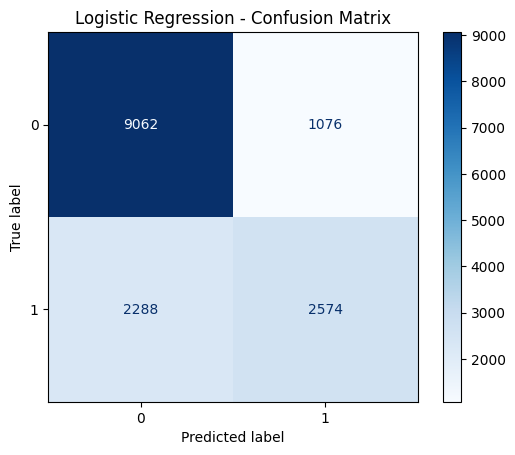

In [162]:
# Creating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')  # You can change color map if you'd like
plt.title("Logistic Regression - Confusion Matrix")

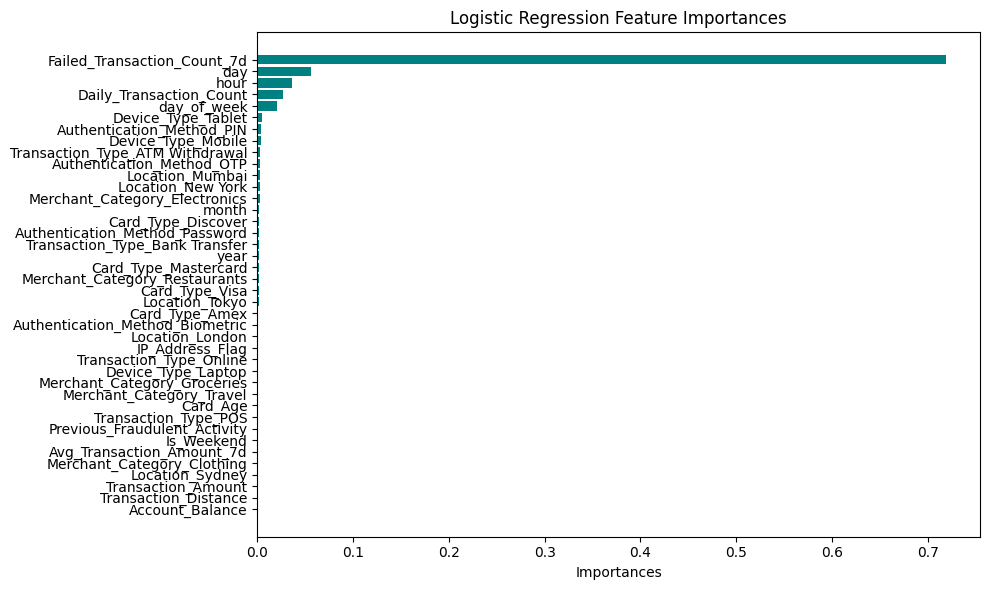

In [163]:
# Getting feature names and coefficients
feature_names = X.columns
coefficients = model.coef_[0]
importance = np.abs(coefficients)

# Creating a DataFrame for easy sorting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=True)  

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel("Importances")
plt.title("Logistic Regression Feature Importances")
plt.tight_layout()
plt.show()

### A logistic model was run first in order to determine if more formatting needed to be done, and get a look at feature importances. Also, if the logistic model had performed well, there may not have been a need to run the more complex random forest model. 
### It produced an f1 score of .77, which is not bad for an initial model, but would need to be improved before implementation. Recall for instances of fraud is where it struggled the most, with a score of .53. This makes sense due to most of the transcations being non-fraudlent, creating a bias towards the majority class. 
### Our top features were 'Failed_Transaction_Count_7d', 'day', 'hour', 'Daily_Transaction_Count', and 'day_of_week'. 

## Creating Random Forest Model

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      6765
           1       1.00      0.62      0.77      3235

    accuracy                           0.88     10000
   macro avg       0.92      0.81      0.84     10000
weighted avg       0.90      0.88      0.87     10000



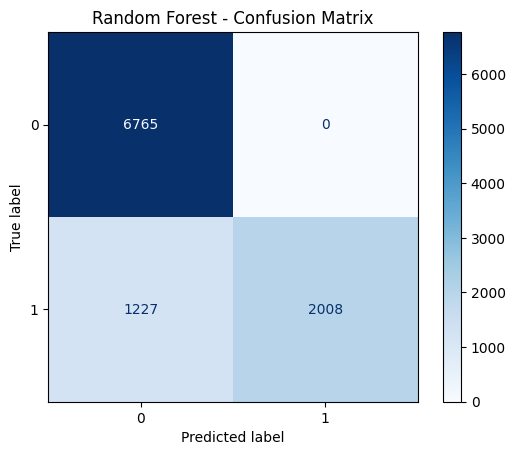

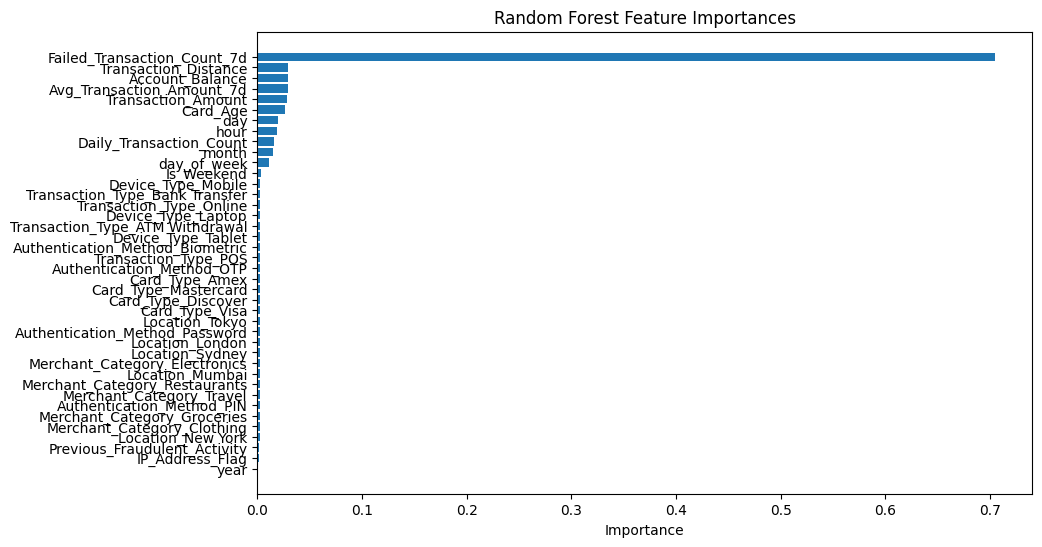

In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

data = data.dropna()  
X = data.drop(columns=['Fraud_Label','Risk_Score'])  
y = data['Fraud_Label']                 

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the model
rf_model = RandomForestClassifier(class_weight= 'balanced', max_depth= 15, max_features= 'sqrt', min_samples_leaf= 3, min_samples_split= 9, n_estimators= 288)
rf_model.fit(X_train, y_train)

# Making predictions
y_pred = rf_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

# Creating Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.show()

# Getting Feature Importance 
importances = rf_model.feature_importances_
feat_names = X.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.show()

ROC AUC Score: 0.8149


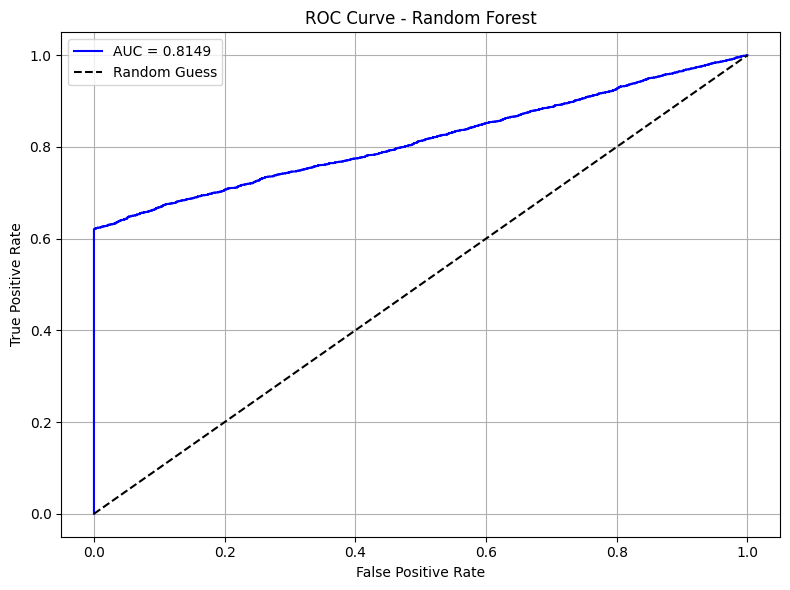

In [165]:
from sklearn.metrics import roc_auc_score, roc_curve

# Getting predicted probabilities for the positive class
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Calculating ROC AUC Score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Testing a model with filtered features based on feature importance

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      6765
           1       1.00      0.62      0.77      3235

    accuracy                           0.88     10000
   macro avg       0.92      0.81      0.84     10000
weighted avg       0.90      0.88      0.87     10000



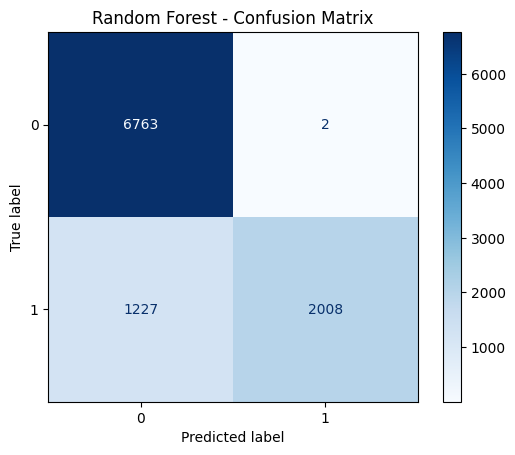

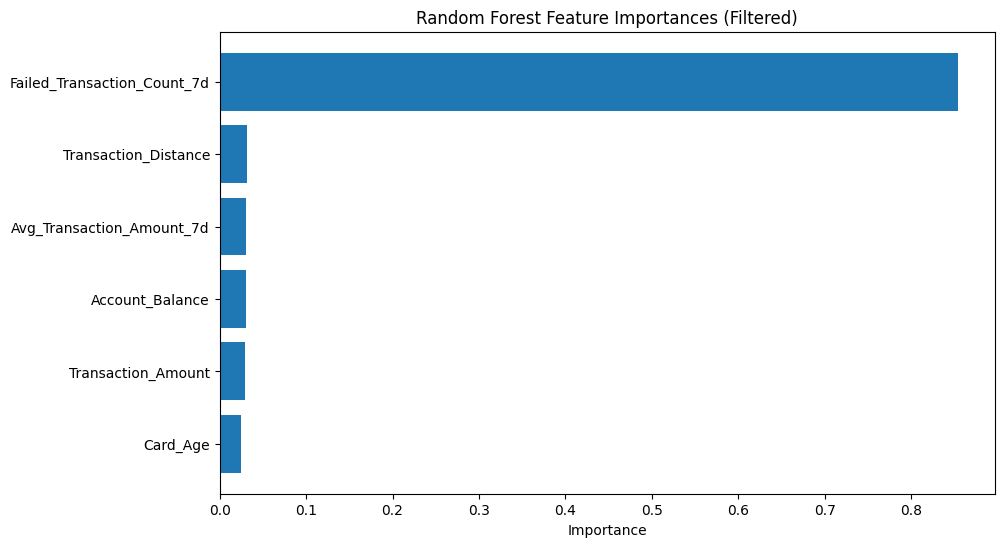

In [166]:
# Setting the threshold for feature importance
threshold = 0.02  # Example threshold

# Filtering features based on importance threshold
important_features = feat_df[feat_df['Importance'] >= threshold]['Feature']
X_filtered = X[important_features]

# Train-Test Split with the filtered features
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

# Initializing and training the model
feat_model = RandomForestClassifier(class_weight= 'balanced', max_depth= 15, max_features= 'sqrt', min_samples_leaf= 3, min_samples_split= 9, n_estimators= 288)
feat_model.fit(X_train, y_train)

# Making predictions
y_pred = feat_model.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=feat_model.classes_)
disp.plot(cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.show()

# Getting Feature Importance for the filtered model
importances = feat_model.feature_importances_
feat_names = X_filtered.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances (Filtered)')
plt.xlabel('Importance')
plt.show()

## Cross-Validiation 

In [167]:
from sklearn.model_selection import cross_val_score

# Random Forest model setup
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='f1')  

# Print results
print("Cross-Validation Scores (f1):", cv_scores)
print("Average CV f1:", np.mean(cv_scores))

Cross-Validation Scores (f1): [0.7563383  0.76825762 0.76849368 0.76692883 0.76527084]
Average CV f1: 0.7650578537835451


## Randomized-Search for Best Parameters

In [168]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from scipy.stats import randint

# Defining the parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

# Setting up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_dist,
                                   n_iter=50,  # try 50 random combinations
                                   cv=5,
                                   scoring='f1',
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=1)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation f1: ", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 288}
Best cross-validation f1:  0.7647717201204077


# Creating Data Frame with Predictions from Random Forest Model

In [169]:
# Creating a new DataFrame with the test set and adding predictions and actuals
results = X_test.copy()
results['actual'] = y_test.values
results['prediction'] = y_pred

In [170]:
# Looking at new dataset
results.head(3)

,Failed_Transaction_Count_7d,Transaction_Distance,Account_Balance,Avg_Transaction_Amount_7d,Transaction_Amount,Card_Age,actual,prediction
33553,3,4568.48,1804.81,350.41,19.98,214,0,0
9427,1,297.39,46648.03,47.14,45.32,78,0,0
199,2,4792.40,80244.56,160.14,32.25,59,0,0


### I first ran the random forest model using default parameters. I then performed a randomized search to determine what the best paramters were for the model. I then changed the parameters of the model to the optimal parameters, and there was no difference in the performance of the model. I then attempted to remove unimportant features to improve the model, but that had little effect.
### The final accuracy score of the model was .90, the final f1 score was .87, and the final ROC AUC score was .81. The accuracy and f1 greatly improved from the logistic to the random forest model. However, when the cross validation was run, it produced an average f1 score of .77, implying that the final model may have trouble with more difficult datasets. Testing this model on real data rather than synthetic data may give better insights on its true performance. 